<a href="https://colab.research.google.com/github/Fukkatsuso/livedoornews-topicmodel/blob/master/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# トピックモデルを使ったWeb記事分類

## 概要
トピックモデルとは，文書が複数のトピックから成り立つと仮定し，文書にトピックがどれくらいの割合で含まれるか予測するモデルである．トピックは「スポーツ」「映画」など事前に決めるものではなく，学習の結果得られる単語の集合で，実際に何に関するトピックなのかは結果を見て人間が判断する．

今回はlivedoorニュースコーパスのトピックモデルを作り，記事のトピック分布から記事のカテゴリを予測する識別器を，機械学習を用いて作る．

ちなみに記事のカテゴリは独女通信（独身女性向けコラム），ITライフハック，家電チャンネル，livedoor HOMME（成人男性向けウェブマガジン），MOVIE ENTER，Peachy（美容），エスマックス（モバイル関連），SportsWatch，トピックニュースの9つがある．

大まかな実装の流れは以下の通り．
1. livedoorニュースコーパスの記事を学習用とテスト用に分ける
1. 記事本文を前処理する
1. 辞書，コーパスを作成する
1. トピックモデルを学習させる
1. トピックモデルの学習データのトピック分布を学習データ，記事のカテゴリをラベルとして識別器を学習させる．
1. テスト用データを識別器にかけ，識別の精度をみる

## 実装

### 準備
下のスクリプトで必要なデータやライブラリを予めインストールしておく．  
日本語の形態素解析はMeCabを使い，分かち書きの精度を上げるためmecab-ipadic-NEologdを辞書として追加した．

In [0]:
# Get dataset
!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz
!mkdir -p dataset/livedoor && tar xvzf ldcc-20140209.tar.gz -C /content/dataset/livedoor --strip-components 1
!rm ldcc-20140209.tar.gz

# Install MeCab
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3

# Install mecab-ipadic-NEologd
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a

!pip install mojimoji

# Japanese font
!apt-get -y install fonts-ipafont-gothic

In [0]:
import gensim
import glob2
import itertools
import matplotlib.pyplot as plt
import MeCab
import mojimoji
import nltk
import numpy as np
import re
import urllib3

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

nltk.download('stopwords')

mecab = MeCab.Tagger("mecabrc -d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd")

### 1. livedoorニュースコーパスの記事を学習用とテスト用に分ける
今回は学習用とテスト用の比率を7:3とした．

In [0]:
paths = glob2.glob("dataset/livedoor/*/*-*.txt")

category = {
  'dokujo-tsushin': 0,
  'it-life-hack': 1,
  'kaden-channel': 2,
  'livedoor-homme': 3,
  'movie-enter': 4,
  'peachy': 5,
  'smax': 6,
  'sports-watch': 7,
  'topic-news': 8
}

category_id = [] # 記事のカテゴリID
url = []      # 記事のURL
date = []     # 記事の日付
title = []    # 記事のタイトル
main = []     # 記事の本文

for path in paths:
  category_id.append(category[path.split('/')[2]])
  data = open(path, 'r', encoding="utf-8").read().split('\n')
  url.append(data[0])
  date.append(data[1])
  title.append(data[2])
  sentences = []
  for line in data[3:]:
    if len(line) > 0:
      sentences.append(line)
  main.append(sentences)

train_rate = 0.8
train_main, test_main, train_label, test_label = train_test_split(main, category_id, train_size=train_rate, random_state=0)

### 2. データの前処理
日本語の文章から，記事の特徴をよく捉えるような単語を抽出していく．

次のような流れで前処理を行う．
  1. 形態素解析
  1. 名詞のみを抽出する
  1. 全角を半角，大文字を小文字に変換し，文字の種類を統一する
  1. ストップワードを除去する

ストップワードには[このページの日本語リスト](http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt)とnltkの英単語リスト，自身で付け加えたいくつかの単語を使用している．

年月日やパーセンテージなど数字を含む語は記事の特徴を捉える語にはなりにくいと考え，抽出の対象から外すこととした．

In [0]:
# ストップワードのリスト
def get_stopwords():
  # SlothLib
  slothlib_url = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
  http = urllib3.PoolManager()
  res = http.request('GET', slothlib_url)
  stopwords = res.data.decode('utf-8').split()
  # nltk
  stopwords.extend(nltk.corpus.stopwords.words("english"))
  # 自分で設定
  swlist = ['さ', 'の', 'ら', 'ん', 'http://', '.com', '.jp', '.net', '.s',]
  stopwords.extend(swlist)
  return stopwords

stopwords = get_stopwords()

# 単語のリストから品詞を限定して取り出す
def extract_by_parts(parsed, parts):
  words = []
  lines = parsed.split('\n')
  for line in lines:
    feature = line.split('\t')
    if len(feature) < 2:
      continue
    info = feature[1].split(',')
    if info[0] in parts:
      if info[6] == '*': 
        words.append(feature[0])  # 活用なしの語
      else:  
        words.append(info[6]) # 表記ゆれの対処
  return words

# 文字種を統一する
def unify_chartype(text):
  text = mojimoji.zen_to_han(text, kana=False, digit=True, ascii=True) # 全角英数=>半角英数
  text = mojimoji.han_to_zen(text, kana=True, digit=False, ascii=False) # 半角かな=>全角かな
  text = text.lower() # 大文字=>小文字
  text = re.sub('\d+', '0', text)  # 数字列を0に置き換え
  return text

# 数字を含む単語を除去する
def filter_num(words):
  filtered_words = [word for word in words if '0' not in word]
  return filtered_words

# ストップワードを除去する
def filter_stopwords(words):
  filtered_words = [word for word in words if word not in stopwords]
  return filtered_words

# 各単語を前処理にかける
def preprocess_words(words):
  for i in range(len(words)):
    words[i] = unify_chartype(words[i])
  words = filter_num(words)
  words = filter_stopwords(words)
  return words

# テキストを分解して品詞で絞り込み，各単語を前処理したリストを返す
def text2words(text, parts):
  parsed_text = mecab.parse(text)
  words = extract_by_parts(parsed_text, parts)
  words = preprocess_words(words)
  return words

# 取り出す品詞
parts = ['名詞']

# 本文から単語を抽出
train_words = [list(itertools.chain.from_iterable([text2words(s, parts) for s in ss])) for ss in train_main]
test_words = [list(itertools.chain.from_iterable([text2words(s, parts) for s in ss])) for ss in test_main]

### 3. 辞書，コーパスを作成する
辞書はIDが割り振られた単語のリストで，コーパスは与えられた単語リストに辞書内の単語がいくつ含まれているかを数えたものである．

辞書については，単語が出現する文書数10以上，文書数の割合20%未満という条件で絞り込みを行った．

In [0]:
# 辞書作成
dictionary = gensim.corpora.Dictionary(train_words)
dictionary.filter_extremes(no_below=10, no_above=0.2)

def words2corpus(dictionary, words):
  return [dictionary.doc2bow(w) for w in words]

# コーパス作成
train_corpus = words2corpus(dictionary, train_words)
test_corpus = words2corpus(dictionary, test_words)

### 4. トピックモデルを学習させる
gensimのLDAModelを使った．トピック数は13とした．

In [46]:
topic_N = 13
lda = gensim.models.ldamodel.LdaModel(corpus=train_corpus, num_topics=topic_N, id2word=dictionary, random_state=0)

for i in range(topic_N):
  print('TOPIC:', i, '=>', lda.print_topic(i))

TOPIC: 0 => 0.009*"%" + 0.007*"ソフトバンク" + 0.005*"チェック" + 0.005*"売れ筋" + 0.004*"節電" + 0.004*"機能" + 0.004*"今年" + 0.004*"調査" + 0.004*"発表" + 0.003*"テレビ"
TOPIC: 1 => 0.013*"男性" + 0.009*"結婚" + 0.006*"恋愛" + 0.006*"女子" + 0.005*"独女" + 0.005*"仕事" + 0.004*"相手" + 0.004*"peachy" + 0.004*"最近" + 0.004*"好き"
TOPIC: 2 => 0.022*"映画" + 0.012*"公開" + 0.009*"作品" + 0.007*"本作" + 0.007*"監督" + 0.004*"世界" + 0.004*"特集" + 0.004*"役" + 0.004*"ファン" + 0.003*"映像"
TOPIC: 3 => 0.018*"アプリ" + 0.013*"画面" + 0.010*"表示" + 0.010*"機能" + 0.007*"android" + 0.007*"設定" + 0.005*"写真" + 0.005*"利用" + 0.005*"smartphone" + 0.004*"便利"
TOPIC: 4 => 0.010*"結婚" + 0.009*"仕事" + 0.005*"男性" + 0.004*"好き" + 0.004*"気持ち" + 0.004*"相手" + 0.004*"氏" + 0.004*"子供" + 0.004*"恋愛" + 0.004*"声"
TOPIC: 5 => 0.011*"肌" + 0.005*"人気" + 0.004*"氏" + 0.004*"ビデオsalon" + 0.004*"作品" + 0.003*"韓国" + 0.003*"クリーム" + 0.003*"アイテム" + 0.003*"成分" + 0.003*"商品"
TOPIC: 6 => 0.009*"機能" + 0.009*"撮影" + 0.007*"サービス" + 0.006*"製品" + 0.006*"テレビ" + 0.006*"利用" + 0.006*"録画" + 0.006*"データ" + 0.006*"対

### 5. 識別器を学習させる
記事のトピック分布を学習データ，記事のカテゴリをラベルとしてランダムフォレストとSVMをそれぞれ学習させ，テスト用データの分類精度を出力させた．

In [54]:
def topic_dist_list(topic_N, topic_dist):
  l = [0] * topic_N
  for topic in topic_dist:
    l[topic[0]] = topic[1]
  return l

# 学習用データ
train_data = [topic_dist_list(topic_N, lda[c]) for c in train_corpus]
# テスト用データ
test_data = [topic_dist_list(topic_N, lda[c]) for c in test_corpus]

# ランダムフォレスト
random_forest = RandomForestClassifier()
random_forest.fit(train_data, train_label)
print('random_forest')
print(random_forest.score(test_data, test_label))

print()

# SVM
svc = SVC()
svc.fit(train_data, train_label)
print('svm')
print(svc.score(test_data, test_label))

random_forest
0.6987788331071914

svm
0.7089552238805971


## 考察
記事分類の精度は，ランダムフォレスト，SVMともに約70%であった．

LDAの結果をWordcloudで可視化すると下の図のようになる．


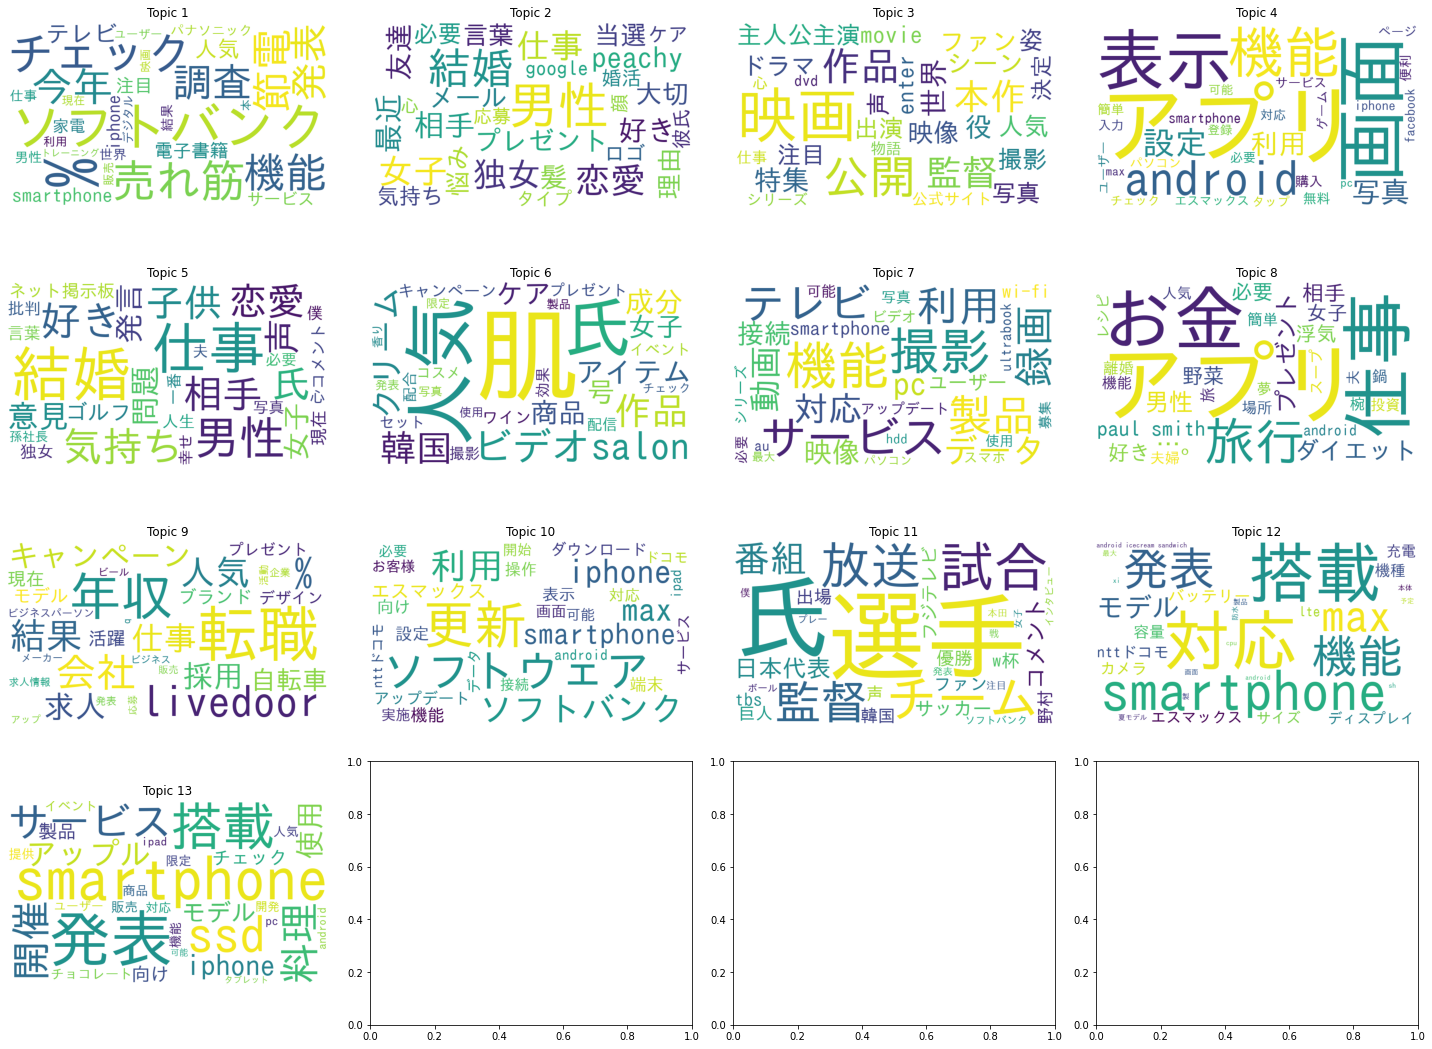

In [48]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def show_wordcloud(lda):
  fig, axs = plt.subplots(ncols=4, nrows=int((lda.num_topics+4-1)/4), figsize=(20,15))
  axs = axs.flatten()

  font_path = '/usr/share/fonts/truetype/fonts-japanese-gothic.ttf'

  for i, t in enumerate(range(lda.num_topics)): 
      x = dict(lda.show_topic(t, 30))
      im = WordCloud(
          width=800, height=460,
          background_color='white',
          random_state=0,
          font_path=font_path
      ).generate_from_frequencies(x)
      axs[i].imshow(im)
      axs[i].axis('off')
      axs[i].set_title('Topic '+str(t+1))

  plt.tight_layout()
  plt.show()

show_wordcloud(lda)

各トピックを大まかにまとめると，次のように分類されているようだった．
- トピック1：家電，スマートフォン
- トピック2：恋愛
- トピック3：映画，ドラマ
- トピック4：IT，スマートフォン
- トピック5：仕事，恋愛
- トピック6：美容
- トピック7：電子機器
- トピック8：人生，生活
- トピック9：仕事
- トピック10：IT，スマートフォン
- トピック11：スポーツ
- トピック12：スマートフォン
- トピック13：スマートフォン，料理?

次に，学習用データとして用いた記事のトピック分布をPCA（主成分分析）で2次元・3次元に次元削減し，プロットしてみた．

分布からは以下のようなことが読み取れる．
- エスマックス，MOVIE ENTER，SportsWatchはある程度はっきりと分布が分かれている
- ITライフハックと家電チャンネルとエスマックス，独女通信とPeachyはそれぞれ類似するカテゴリで，それが分布にも現れている
- トピックニュースの分布がまばらになっているのは，このカテゴリが一時的なニュースを取り扱っており，明確なテーマを持ったカテゴリではないためと考えられる

WordcloudでもIT・家電系や恋愛，スポーツに関連した単語がよく現れていたから，このような結果には納得がいく．  

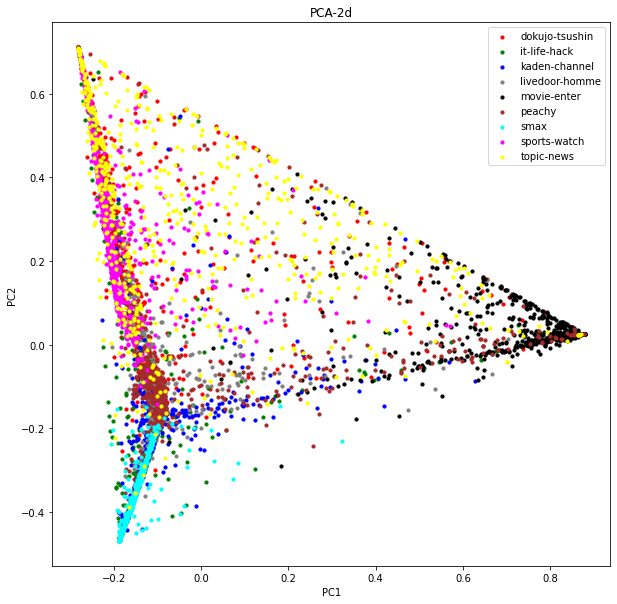

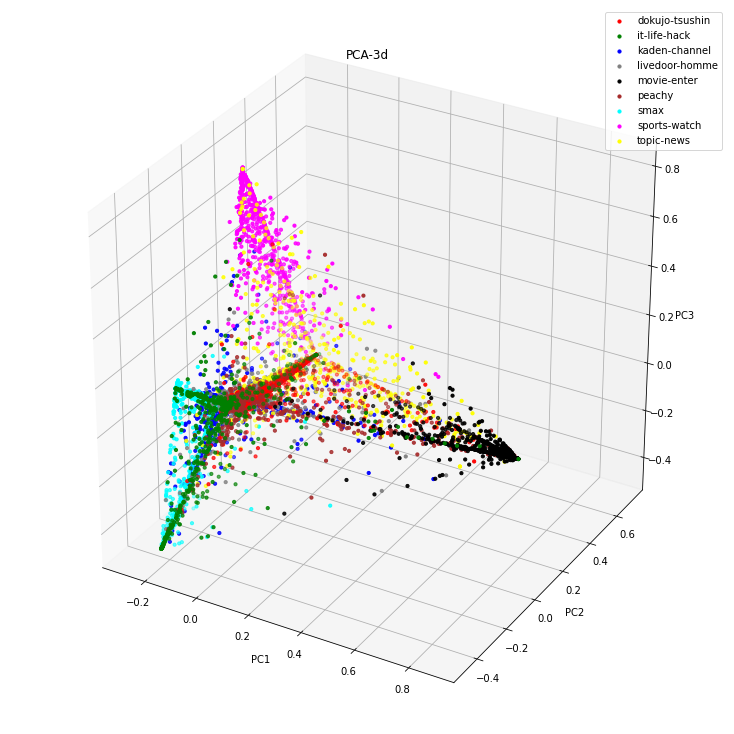

In [49]:
# pca
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

color = ['red', 'green', 'blue', 'gray', 'black', 'brown', 'cyan', 'magenta', 'yellow']

# 2次元のPCA
def plot_pca_2d(data, label, title, figname):
  pca = PCA(n_components=2)
  pca_X = pca.fit_transform(data)

  pca_X_group_x = [[] for i in range(len(category))]
  pca_X_group_y = [[] for i in range(len(category))]
  for i in range(len(pca_X)):
    pca_X_group_x[label[i]].append(pca_X[i][0])
    pca_X_group_y[label[i]].append(pca_X[i][1])

  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)

  for i in range(len(category)):
    ax.scatter(pca_X_group_x[i], pca_X_group_y[i], c=color[i], label=list(category)[i], s=10)

  ax.set_title(title)
  ax.set_xlabel('PC1')
  ax.set_ylabel('PC2')
  ax.legend()

  plt.show()
  fig.savefig(figname)

# 3次元のPCA
def plot_pca_3d(data, label, title, figname):
  pca = PCA(n_components=3)
  pca_X = pca.fit_transform(data)

  pca_X_group_x = [[] for i in range(len(category))]
  pca_X_group_y = [[] for i in range(len(category))]
  pca_X_group_z = [[] for i in range(len(category))]
  for i in range(len(pca_X)):
    pca_X_group_x[label[i]].append(pca_X[i][0])
    pca_X_group_y[label[i]].append(pca_X[i][1])
    pca_X_group_z[label[i]].append(pca_X[i][2])

  fig = plt.figure(figsize=(10,10))
  ax = Axes3D(fig)

  for i in range(len(category)):
    ax.scatter3D(pca_X_group_x[i], pca_X_group_y[i], pca_X_group_z[i], c=color[i], label=list(category)[i], s=10)

  ax.set_title(title)
  ax.set_xlabel('PC1')
  ax.set_ylabel('PC2')
  ax.set_zlabel('PC3')
  ax.legend()

  plt.show()
  fig.savefig(figname)

plot_pca_2d(train_data, train_label, 'PCA-2d', 'pca-2d.png')
plot_pca_3d(train_data, train_label, 'PCA-3d', 'pca-3d.png')

## 今後の課題
WordcloudやPCAによる可視化の結果から，カテゴリ「トピックニュース」の記事を判別するのは困難なことだと予想できる．このカテゴリを学習の対象から外した場合に他のカテゴリの予測精度が向上するのか，試してみたい．

トピックモデルや分類器の学習の際に細かなパラメータを調整していなかったことも原因の一つとして考えられる．どれほど影響するのか不明だが，確かめるためにもパラメータのチューニングは今後の課題としたい．

## 参考
- [トピックモデルとは | データ分析基礎知識 - 株式会社ALBERT](https://www.albert2005.co.jp/knowledge/machine_learning/topic_model/about_topic_model)
- [LDAによるトピックモデル with gensim ~ Qiitaのタグからユーザーの嗜好を考える ~](https://qiita.com/shizuma/items/44c016812552ba8a8b88)
- [トピックモデルをザックリと理解してサクッと試した](https://qiita.com/d-ogawa/items/c423cd4b01c6ed84a5e7)
- [WordCloudとpyLDAvisによるLDAの可視化について](http://www.ie110704.net/2018/12/29/wordcloud%E3%81%A8pyldavis%E3%81%AB%E3%82%88%E3%82%8Blda%E3%81%AE%E5%8F%AF%E8%A6%96%E5%8C%96%E3%81%AB%E3%81%A4%E3%81%84%E3%81%A6/)
- [自然言語処理による文書分類の基礎の基礎、トピックモデルを学ぶ](https://qiita.com/icoxfog417/items/7c944cb29dd7cdf5e2b1)
- [scikit-learnとgensimでニュース記事を分類する](https://qiita.com/yasunori/items/31a23eb259482e4824e2)
- [文書分類で自然言語処理に触れる](https://colab.research.google.com/drive/1IMjc-RTesapfNCEh0TPmg_ce_qAcV95b#scrollTo=9a9CUjgUXgB6)
- [自然言語処理における前処理の種類とその威力](https://qiita.com/Hironsan/items/2466fe0f344115aff177)
- [Python3×日本語：自然言語処理の前処理まとめ](https://qiita.com/chamao/items/7edaba62b120a660657e)
- [ニュース記事の分類を機械学習で予測する](https://qiita.com/hyo_07/items/ba3d53868b2f55ed9941)
- [LDA実践編：20newsgroupsでサクッとトピックモデリング](https://www.dendoron.com/boards/59)